In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sajid576/sql-injection-dataset")

print("Path to dataset files:", path)

100%|██████████| 425k/425k [00:00<00:00, 555kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sajid576/sql-injection-dataset/versions/1


# Step 1: Environment Setup and Dataset Download

# 1.1. Install Required Libraries

In [2]:
# Install required libraries
!pip install kagglehub
!pip install pandas scikit-learn numpy tensorflow keras matplotlib seaborn


# 1.2. Import Standard Libraries

In [3]:
# General purpose
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 1.3. Download SQLi Dataset from Kaggle (Using kagglehub)

In [4]:
import kagglehub

# Download the SQL Injection dataset
path = kagglehub.dataset_download("sajid576/sql-injection-dataset")

# Confirm the download path
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/sql-injection-dataset


# 1.4. Load the Dataset into DataFrame

In [5]:
import os

# List files to verify path
for root, dirs, files in os.walk(path):
    for f in files:
        print("File found:", os.path.join(root, f))


file_path = os.path.join(path, "data", "/kaggle/input/sql-injection-dataset/Modified_SQL_Dataset.csv")  # Adjust this based on printed output
df = pd.read_csv(file_path)

# Preview
print("Dataset shape:", df.shape)
df.head()


File found: /kaggle/input/sql-injection-dataset/.nfs00000000367be1c10000001b
File found: /kaggle/input/sql-injection-dataset/Modified_SQL_Dataset.csv
Dataset shape: (30919, 2)


,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


# Step 1.6: Data Exploration and Visualization

# 1.6.1 Check Basic Info and Null Values

In [6]:
# Dataset summary
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

# Null checks
print("\nMissing values:\n", df.isnull().sum())


Dataset shape: (30919, 2)

Column names: ['Query', 'Label']

Data types:
 Query    object
Label     int64
dtype: object

Missing values:
 Query    0
Label    0
dtype: int64


# 1.6.2 Label Distribution


Label Distribution:
 Label
0    19537
1    11382
Name: count, dtype: int64


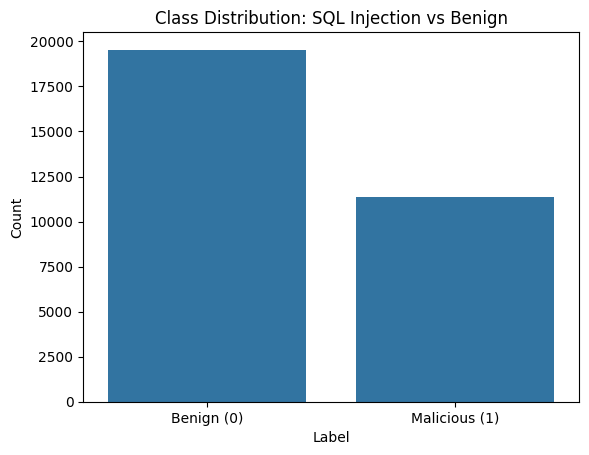

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Label counts
label_counts = df['Label'].value_counts()
print("\nLabel Distribution:\n", label_counts)

# Bar plot
sns.countplot(x='Label', data=df)
plt.title("Class Distribution: SQL Injection vs Benign")
plt.xticks([0, 1], ['Benign (0)', 'Malicious (1)'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# 1.6.3 Query Length Analysis


Query Length Stats:
 count    30919.000000
mean        68.882888
std         81.144952
min          1.000000
25%         21.000000
50%         48.000000
75%         81.000000
max       5370.000000
Name: Query_Length, dtype: float64


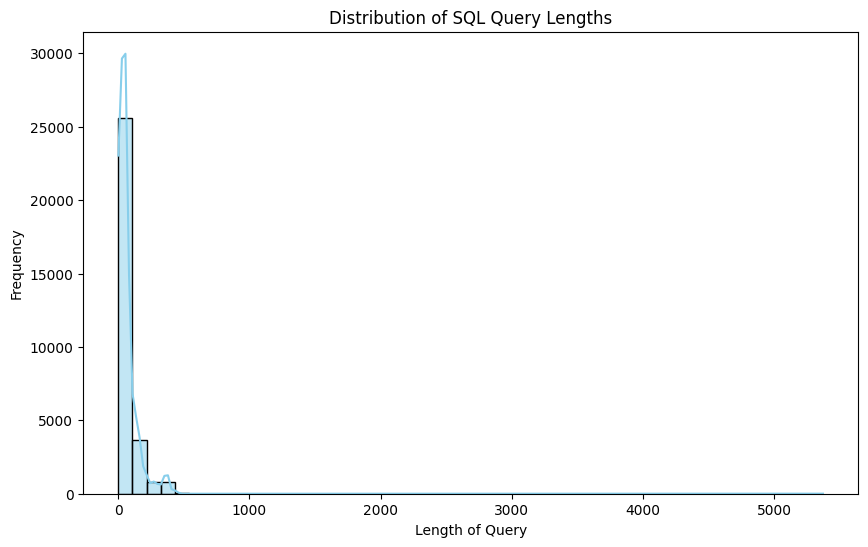

In [8]:
# Create a new column for query lengths
df['Query_Length'] = df['Query'].apply(len)

# Summary statistics
print("\nQuery Length Stats:\n", df['Query_Length'].describe())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Query_Length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of SQL Query Lengths")
plt.xlabel("Length of Query")
plt.ylabel("Frequency")
plt.show()


# 1.6.4 Word Cloud for Malicious vs Benign Queries

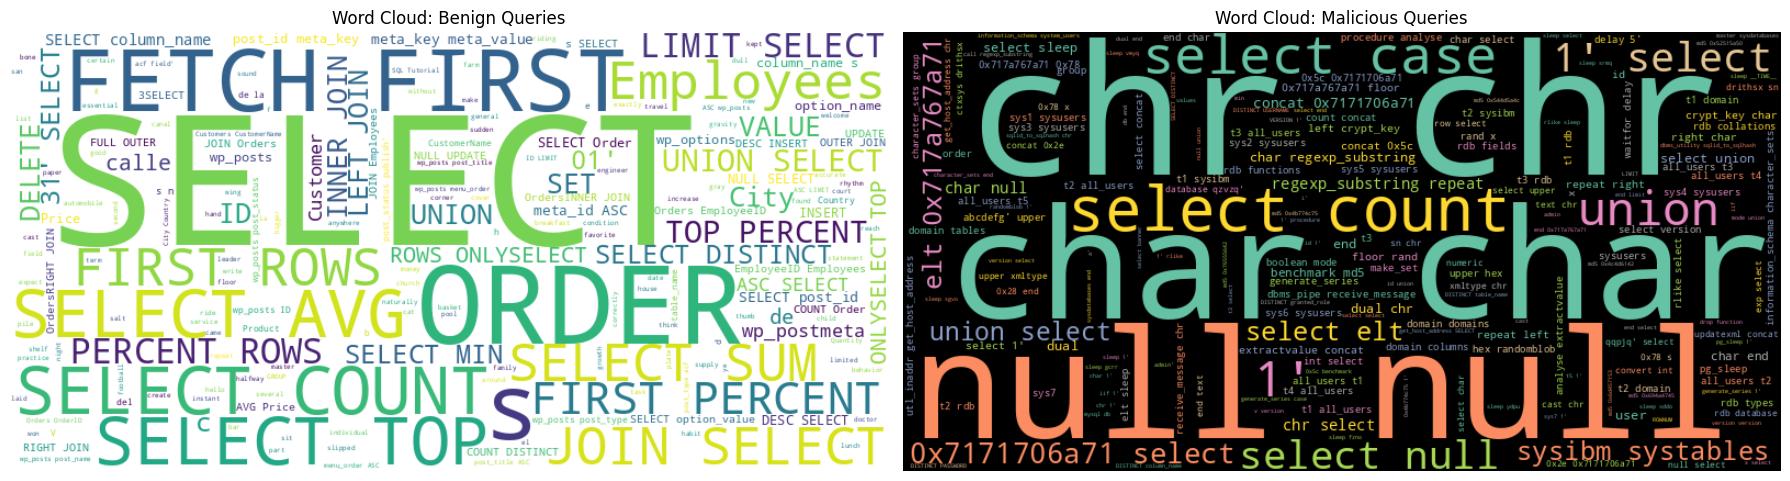

In [9]:
from wordcloud import WordCloud

# Separate benign and malicious queries
benign_queries = " ".join(df[df['Label'] == 0]['Query'].astype(str))
malicious_queries = " ".join(df[df['Label'] == 1]['Query'].astype(str))

# Plot word clouds
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

wordcloud_benign = WordCloud(width=800, height=400, background_color='white').generate(benign_queries)
axs[0].imshow(wordcloud_benign, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("Word Cloud: Benign Queries")

wordcloud_malicious = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(malicious_queries)
axs[1].imshow(wordcloud_malicious, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("Word Cloud: Malicious Queries")

plt.tight_layout()
plt.show()


# 1.6.5 Keyword Frequency in Malicious Queries

/tmp/ipython-input-1734761350.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Token', data=token_df, palette='Reds_r')


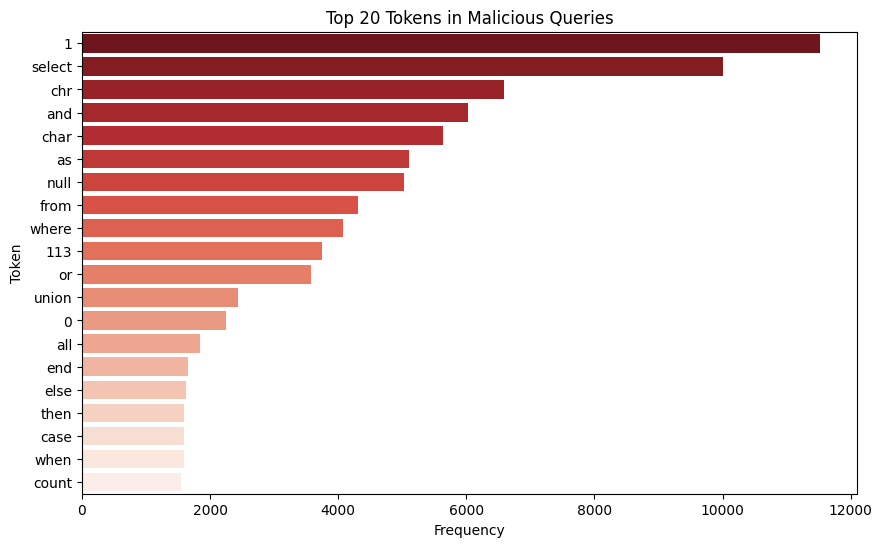

In [10]:
from collections import Counter
import re

# Tokenize malicious queries
malicious_tokens = " ".join(df[df['Label'] == 1]['Query'].astype(str))
tokens = re.findall(r'\b\w+\b', malicious_tokens.lower())

# Most common tokens
common_tokens = Counter(tokens).most_common(20)
token_df = pd.DataFrame(common_tokens, columns=['Token', 'Frequency'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Token', data=token_df, palette='Reds_r')
plt.title("Top 20 Tokens in Malicious Queries")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()


#  STEP 1.7: GAN/VAE-based Data Augmentation for SQLi Dataset

In [13]:
import re
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# ===== Step 0: Load your dataset =====
# Make sure 'df' is loaded from Step 1 output
# Example:
# df = pd.read_csv("/path/to/SQLi.csv")

print("Original Columns:", df.columns)

# ===== Step 1: Clean Queries =====
def clean_sql_query(query):
    query = query.lower()
    query = re.sub(r"[^a-z0-9\s]", " ", query)  # keep alphanumeric only
    query = re.sub(r"\s+", " ", query).strip()   # normalize spaces
    return query

df["Clean_Query"] = df["Query"].apply(clean_sql_query)

print("\nSample cleaned queries:")
print(df["Clean_Query"].head())

# ===== Step 2: Tokenization =====
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Clean_Query"])
sequences = tokenizer.texts_to_sequences(df["Clean_Query"])
max_seq_len = max(len(seq) for seq in sequences)
vocab_size = len(tokenizer.word_index) + 1

padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding="post")

# ===== Step 3: Prepare data for GAN =====
X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)

# ===== Step 4: Simple LSTM Generator Model =====
generator = Sequential()
generator.add(Embedding(vocab_size, 50, input_length=max_seq_len-1))
generator.add(LSTM(100, return_sequences=False))
generator.add(Dense(vocab_size, activation="softmax"))

generator.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

# ===== Step 5: Train the generator model =====
generator.fit(X, y, epochs=5, verbose=1)

# ===== Step 6: Generate new synthetic queries =====
def generate_query(seed_text, num_words=5):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding="post")
        predicted_probs = generator.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted_probs, axis=-1)[0]
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                seed_text += " " + word
                break
    return seed_text

# Generate examples
synthetic_queries = [generate_query(seed, num_words=5) for seed in df["Clean_Query"].sample(5)]
print("\nSynthetic Queries:")
for q in synthetic_queries:
    print(q)

# ===== Step 7: Append synthetic data to dataset =====
synthetic_df = pd.DataFrame({
    "Query": synthetic_queries,
    "Label": 1  # Assume 1 for malicious (you can mix benign/malicious)
})

df_augmented = pd.concat([df, synthetic_df], ignore_index=True)
print("\nAugmented dataset size:", df_augmented.shape)


Original Columns: Index(['Query', 'Label', 'Query_Length'], dtype='object')

Sample cleaned queries:
0                                     or pg sleep time
1    create user name identified by pass123 tempora...
2    and 1 utl inaddr get host address select disti...
3    select from users where id 1 or 1 1 union sele...
4    select from users where id 1 or 1 union select...
Name: Clean_Query, dtype: object


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
967/967 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9923 - loss: 1.3682
Epoch 2/5
967/967 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 3/5
967/967 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9999 - loss: 9.8187e-04
Epoch 4/5
967/967 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 1.0000 - loss: 3.1554e-04
Epoch 5/5
967/967 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 1.0000 - loss: 5.8736e-04

Synthetic Queries:
1 rlike sleep 5 muhp
6803 order by 1
5580 or 4829 1968
1 and 3715 in char 113 char 113 char 112 char 106 char 113 select case when 3715 3715 then char 49 else char 48 end char 113 char 122 char 118 char 122 char 113 and
1 or 4915 select count from domain domains as t1 domain columns as t2 domain tables as t3

Augmented dataset size: (30924, 4)


In [22]:
df_augmented.to_csv("df_augmented.csv", index=False, encoding="utf-8")
print("Augmented dataset saved as df_augmented.csv")


Augmented dataset saved as df_augmented.csv


# Step 2: Preprocessing and Feature Engineering

# 2.1 Clean Text

In [14]:
import re

def clean_query(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces
    text = re.sub(r'[^\w\s\'";=<>*/%-]', '', text)  # Keep SQL-relevant symbols
    return text.strip()

df['Clean_Query'] = df['Query'].astype(str).apply(clean_query)


# 2.2 TF-IDF Vectorization for ML Models

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer with max features
tfidf = TfidfVectorizer(max_features=5000)

# Transform queries into TF-IDF matrix
X_tfidf = tfidf.fit_transform(df['Clean_Query']).toarray()
y = df['Label'].values

# Split into train/test/validation
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (21643, 5000)
Validation shape: (4638, 5000)
Test shape: (4638, 5000)


# 2.3 Tokenizer and Padding (for LSTM model)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer setup
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Clean_Query'])

# Convert to sequences
sequences = tokenizer.texts_to_sequences(df['Clean_Query'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split padded sequences
X_train_pad, X_temp_pad, y_train_pad, y_temp_pad = train_test_split(padded_sequences, y, test_size=0.30, stratify=y, random_state=42)
X_val_pad, X_test_pad, y_val_pad, y_test_pad = train_test_split(X_temp_pad, y_temp_pad, test_size=0.50, stratify=y_temp_pad, random_state=42)

print("Padded Sequence Shape:", padded_sequences.shape)


Padded Sequence Shape: (30919, 100)


# Step 3: Model Development (Detection System)

#  3.1 Random Forest Classifier (TF-IDF)

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2931
           1       1.00      0.99      0.99      1707

    accuracy                           0.99      4638
   macro avg       1.00      0.99      0.99      4638
weighted avg       0.99      0.99      0.99      4638



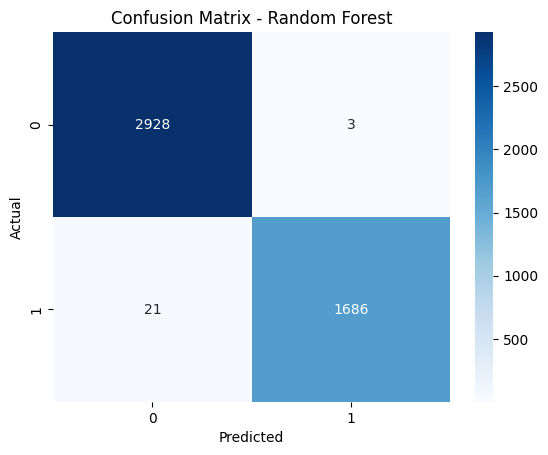

AUC Score: 0.9933


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf_model.fit(X_train, y_train)

# Predict on test set
rf_preds = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, rf_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AUC Score
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"AUC Score: {rf_auc:.4f}")


# 3.2 LSTM Classifier (Tokenized Padded Input)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = lstm_model.fit(X_train_pad, y_train_pad, validation_data=(X_val_pad, y_val_pad), epochs=100, batch_size=64)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6254 - loss: 0.6629 - val_accuracy: 0.6317 - val_loss: 0.6580
Epoch 2/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6321 - loss: 0.6602 - val_accuracy: 0.6317 - val_loss: 0.6617
Epoch 3/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6316 - loss: 0.6599 - val_accuracy: 0.6317 - val_loss: 0.6580
Epoch 4/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6272 - loss: 0.6619 - val_accuracy: 0.6317 - val_loss: 0.6581
Epoch 5/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6341 - loss: 0.6577 - val_accuracy: 0.6317 - val_loss: 0.6585
Epoch 6/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6270 - loss: 0.6612 - val_accuracy: 0.6317 - val_loss: 0.6580
Epoch 7/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6296 - loss: 0.6596 - val_accuracy: 0.6317 - val_loss: 0.6581
Epoch 8/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6284 - loss: 0.6610 - val_accuracy: 0.6317

# 3.3 LSTM Evaluation

LSTM Test Accuracy: 0.6320
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      2931
           1       0.00      0.00      0.00      1707

    accuracy                           0.63      4638
   macro avg       0.32      0.50      0.39      4638
weighted avg       0.40      0.63      0.49      4638



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


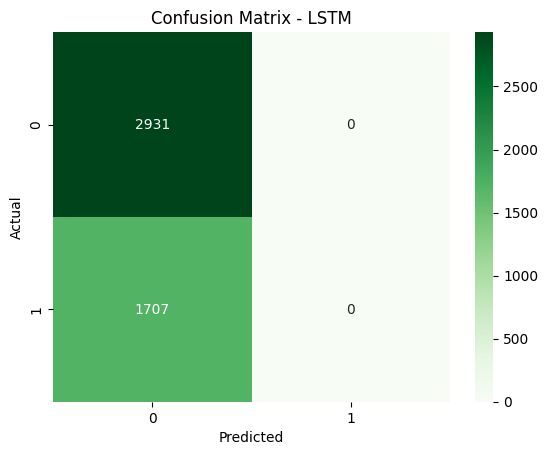

In [19]:
# Evaluate on test data
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test_pad, verbose=0)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")

# Predictions
lstm_preds = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Classification report
print("LSTM Classification Report:\n")
print(classification_report(y_test_pad, lstm_preds))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_pad, lstm_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Plot LSTM Training Curve

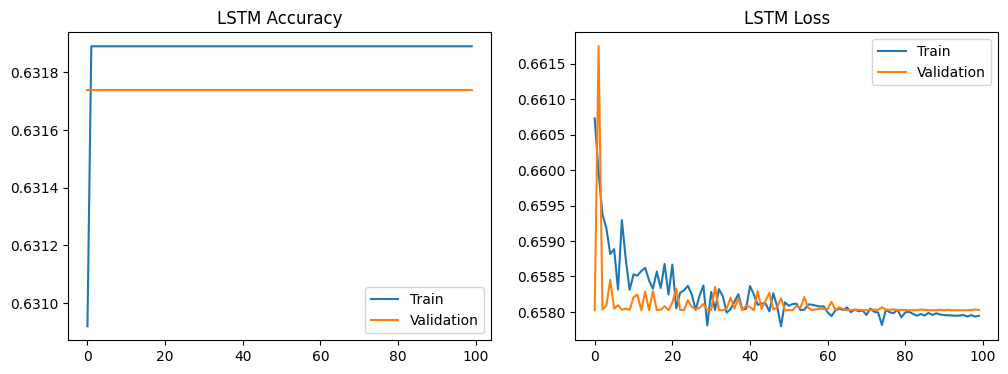

In [20]:
# Accuracy & Loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("LSTM Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("LSTM Loss")
plt.legend()
plt.show()


# STEP 4: Combined Model Development – RF, IF, and LSTM

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ===== Load Augmented Dataset =====
# Ensure this file is generated from Step 1 + GAN Augmentation
df = pd.read_csv("df_augmented.csv")

# Features & Labels
X_text = df["Query"]
y = df["Label"]

# ======== TEXT VECTORIZATION FOR RF & IF ========
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text).toarray()

# Train-Test Split for supervised models
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# ===== 1. Random Forest Classifier =====
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n[Random Forest Results]")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Save RF model
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# ===== 2. Isolation Forest (Unsupervised) =====
print("\nTraining Isolation Forest...")
if_model = IsolationForest(contamination=0.1, random_state=42)
if_model.fit(X_tfidf)

# Predict: -1 = anomaly, 1 = normal
y_pred_if = if_model.predict(X_tfidf)
y_pred_if = np.where(y_pred_if == -1, 1, 0)  # 1 = malicious, 0 = benign

print("\n[Isolation Forest Results]")
print(classification_report(y, y_pred_if))
print("Accuracy:", accuracy_score(y, y_pred_if))





Training Random Forest...

[Random Forest Results]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3927
           1       1.00      0.99      0.99      2258

    accuracy                           1.00      6185
   macro avg       1.00      0.99      1.00      6185
weighted avg       1.00      1.00      1.00      6185

Accuracy: 0.9957962813257882

Training Isolation Forest...

[Isolation Forest Results]
              precision    recall  f1-score   support

           0       0.68      0.96      0.80     19537
           1       0.77      0.21      0.33     11387

    accuracy                           0.69     30924
   macro avg       0.72      0.59      0.56     30924
weighted avg       0.71      0.69      0.62     30924

Accuracy: 0.6857133617901953


Dataset columns: Index(['Query', 'Label', 'Query_Length', 'Clean_Query'], dtype='object')

Random Forest Accuracy: 0.9964430072756669
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3927
           1       1.00      0.99      1.00      2258

    accuracy                           1.00      6185
   macro avg       1.00      1.00      1.00      6185
weighted avg       1.00      1.00      1.00      6185



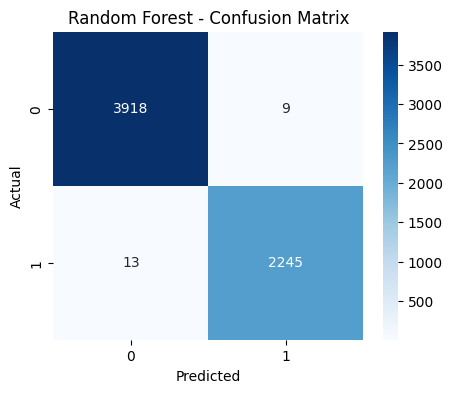


Isolation Forest Accuracy: 0.6819725141471301
              precision    recall  f1-score   support

           0       0.68      0.96      0.79      3927
           1       0.73      0.20      0.32      2258

    accuracy                           0.68      6185
   macro avg       0.70      0.58      0.56      6185
weighted avg       0.70      0.68      0.62      6185



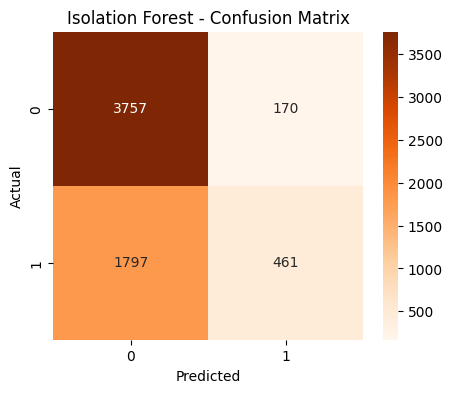

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


387/387 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.6253 - loss: 0.6622 - val_accuracy: 0.6349 - val_loss: 0.6565
194/194 ━━━━━━━━━━━━━━━━━━━━ 54s 275ms/step

LSTM Accuracy: 0.6349232012934519
              precision    recall  f1-score   support

           0       0.63      1.00      0.78      3927
           1       0.00      0.00      0.00      2258

    accuracy                           0.63      6185
   macro avg       0.32      0.50      0.39      6185
weighted avg       0.40      0.63      0.49      6185



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


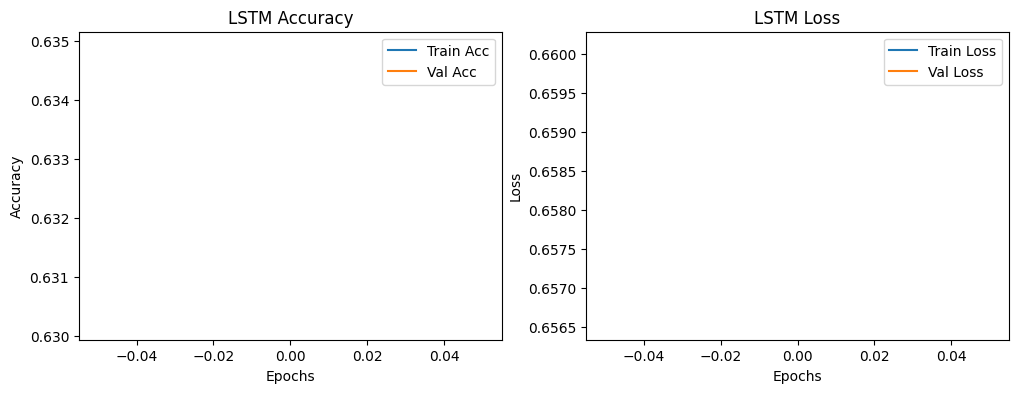


Model Performance Comparison:
              Model  Accuracy
0     Random Forest  0.996443
1  Isolation Forest  0.681973
2              LSTM  0.634923


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# ===============================
# Load Dataset
# ===============================
df = pd.read_csv("df_augmented.csv")  # Change to your file
print("Dataset columns:", df.columns)

# Ensure Clean_Query exists and is string type
if "Clean_Query" not in df.columns:
    raise ValueError("'Clean_Query' column missing. Please run preprocessing before this step.")

df["Clean_Query"] = df["Clean_Query"].fillna("").astype(str)

# ===============================
# Tokenization
# ===============================
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Clean_Query"])
sequences = tokenizer.texts_to_sequences(df["Clean_Query"])
max_seq_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding="post")

X = padded_sequences
y = df["Label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# Random Forest
# ===============================
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# Confusion Matrix RF
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================
# Isolation Forest (Unsupervised)
# ===============================
iso_model = IsolationForest(contamination=0.1, random_state=42)
iso_model.fit(X_train)
iso_preds = iso_model.predict(X_test)

# Map predictions: IF gives -1 (anomaly) & 1 (normal), so adjust for binary labels
iso_preds = np.where(iso_preds == -1, 1, 0)

print("\nIsolation Forest Accuracy:", accuracy_score(y_test, iso_preds))
print(classification_report(y_test, iso_preds))

# Confusion Matrix IF
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, iso_preds), annot=True, fmt="d", cmap="Oranges")
plt.title("Isolation Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================
# LSTM Model
# ===============================
vocab_size = len(tokenizer.word_index) + 1
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 100, input_length=max_seq_len))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(2, activation="softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = lstm_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                         epochs=1, batch_size=64, verbose=1)

lstm_preds = np.argmax(lstm_model.predict(X_test), axis=1)
print("\nLSTM Accuracy:", accuracy_score(y_test, lstm_preds))
print(classification_report(y_test, lstm_preds))

# LSTM Training Accuracy & Loss Graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("LSTM Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("LSTM Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===============================
# Model Comparison Table
# ===============================
results_df = pd.DataFrame({
    "Model": ["Random Forest", "Isolation Forest", "LSTM"],
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, iso_preds),
        accuracy_score(y_test, lstm_preds)
    ]
})

print("\nModel Performance Comparison:")
print(results_df)


/tmp/ipython-input-204386243.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


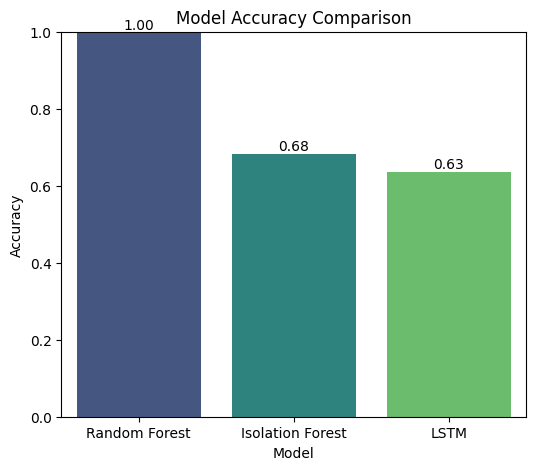

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


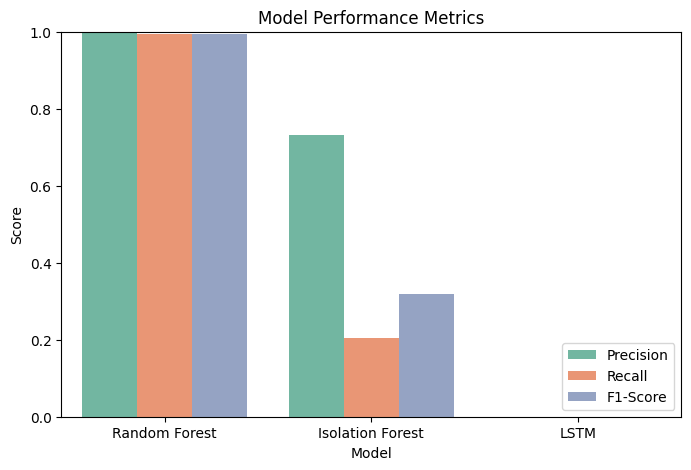

In [31]:
# ===============================
# Model Performance Visualization
# ===============================
# Accuracy Comparison
plt.figure(figsize=(6, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
for i, acc in enumerate(results_df["Accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)
plt.show()

# ===============================
# Detailed Metrics Visualization (Optional)
# ===============================
# If you want precision, recall, f1-score as well
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "Isolation Forest", "LSTM"],
    "Precision": [
        precision_score(y_test, rf_preds),
        precision_score(y_test, iso_preds),
        precision_score(y_test, lstm_preds)
    ],
    "Recall": [
        recall_score(y_test, rf_preds),
        recall_score(y_test, iso_preds),
        recall_score(y_test, lstm_preds)
    ],
    "F1-Score": [
        f1_score(y_test, rf_preds),
        f1_score(y_test, iso_preds),
        f1_score(y_test, lstm_preds)
    ]
})

metrics_df_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_df_melted, palette="Set2")
plt.title("Model Performance Metrics")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib

# ===== Load Dataset =====
df = pd.read_csv("df_augmented.csv")  # or your final processed dataset
X = df["Query"]          # Text data
y = df["Label"]          # Labels

# ===== Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== TF-IDF Vectorization =====
# DO NOT set random max_features unless intended
tfidf_vectorizer = TfidfVectorizer(max_features=None)  # keep consistent
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# ===== Train Random Forest =====
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# ===== Evaluation =====
y_pred = rf_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ===== Save Model & Vectorizer for Flask =====
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

print("✅ RF model and TF-IDF vectorizer saved successfully!")


Accuracy: 0.8043654001616815
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      3927
           1       0.65      0.99      0.79      2258

    accuracy                           0.80      6185
   macro avg       0.82      0.84      0.80      6185
weighted avg       0.87      0.80      0.81      6185

✅ RF model and TF-IDF vectorizer saved successfully!
